In [1]:
"""
APPLY BAYESIAN NEURAL NETWORK ON APOGEE-TGAS DR14 DATA
"""
%matplotlib inline 
from scipy.stats import kde
import scipy
import CalcBNN as cbnn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read APOGEE-TGAS data

In [2]:
# Read data file ("location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff","teff_err","logg","logg_err",
#        "m_h","m_h_err","alpha_m","alpha_m_err"],elarrdef,elarrdef_err,["ra_gaia","dec_gaia","ra_error","dec_error","parallax","parallax_error","pmra","pmra_error","pmdec",
#        "pmdec_error","meandist","diststd","lncanmass","elncanmass","lncanage","elncanage","kepmass","kepmass68L",
#        "kepmass68U","kepmass95L","kepmass95U","kepage","kepage68L","kepage68U","kepage95L","kepage95U",
#        "kepevstate")
datafile = "../data/apogee/APOGEE_TGAS_DR14_supp_keplercannon_masses_ages.csv"
data     = pd.read_csv(datafile,header=0,index_col=0) 
nstars   = len(data)  
                
print("The number of stars in the APOGEE-TGAS DR14 sample is:")
print(nstars)  

The number of stars in the APOGEE-TGAS DR14 sample is:
10074


# Select inputs

In [35]:
# Select inputs and errors
inputs = np.column_stack((data["logg"].values,data["teff"].values,data["m_h"].values,data["[C/M]"].values,
                          data["[CI/M]"].values,data["[N/M]"].values,data["[O/M]"].values,
                          data["[Mg/M]"].values,data["[Si/M]"].values,data["[P/H]"].values,
                          data["[K/H]"].values,data["[Ti/M]"].values,data["[Mn/H]"].values,
                          data["[Co/H]"].values,data["[Ni/H]"].values))
#inputs = np.column_stack((data["logg"].values,data["teff"].values,data["m_h"].values,data["[C/M]"].values,
#                          data["[N/M]"].values,data["[O/M]"].values))
ninputs = len(inputs[0,:])
print(ninputs)

errInputs = np.column_stack((data["logg_err"].values,data["teff_err"].values,data["m_h_err"].values,
                             data["err_[C/M]"].values,data["err_[CI/M]"].values,data["err_[N/M]"].values,
                             data["err_[O/M]"].values,data["err_[Mg/M]"].values,data["err_[Si/M]"].values,
                             data["err_[P/H]"].values,data["err_[K/H]"].values,data["err_[Ti/M]"].values,
                             data["err_[Mn/H]"].values,data["err_[Co/H]"].values,data["err_[Ni/H]"].values))  
#errInputs = np.column_stack((data["logg_err"].values,data["teff_err"].values,data["m_h_err"].values,
#                             data["err_[C/M]"].values,data["err_[N/M]"].values,data["err_[O/M]"].values))

15
Found 1312 stars with Kepler masses.


# Calculate masses

In [6]:
# Instantiate class
bnn = cbnn.CalcBNN()

# Number of neurons per hidden layer
neuronsPerHiddenlayer = 30

# Whether to use NUTS or ADVI sampler
sampler               = "nuts"

# Number of samples tro draw from posterior
nsamp                 = 5000

# Pickle file for storing model
tracedir = "../results/apogee/mass/"
bnnmodelpkl = tracedir+"bnn_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".pkl"
print(bnnmodelpkl)

# Directory for storing plots
plotdir     = "../plots/apogee/mass/"
print(plotdir)
ncores      = 2

# Number of posterior predictive samples
nppc = 5000 

# Apply model
out = bnn.calcPostPredSamples(bnnmodelpkl,inputs,errInputs,nppc,plotdir)

inputsTrueMu   = out["InputsTrueMu"]
inputsTrueSig  = out["InputsTrueSig"]
targetsTrueMu  = out["TargetsTrueMu"]
targetsTrueSig = out["TargetsTrueSig"]

The number of stars in the APOGEE-TGAS DR14 sample is:
10074


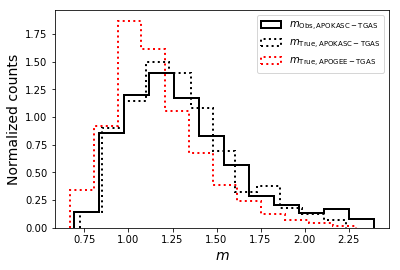

In [52]:
# Read APOKASC masses and predicted masses
datafile     = "../data/apogee/APOKASC_TGAS_supp_keplercannonann_masses_ages.csv"
dataApokasc  = pd.read_csv(datafile,header=0,index_col=0)
obsmass      = dataApokasc["kepmass"]
predmass     = dataApokasc["annMass"]
                
print("The number of stars in the APOGEE-TGAS DR14 sample is:")
print(nstars)         

fig = plt.figure(figsize=(6,4))
plt.hist(obsmass,histtype="step",bins=12,normed=True,linewidth=2,color="black",label=r"$m_{\mathrm{Obs,APOKASC-TGAS}}$")
plt.hist(predmass,histtype="step",bins=12,normed=True,linewidth=2,linestyle=":",color="black",label=r"$m_{\mathrm{True,APOKASC-TGAS}}$")
plt.hist(targetsTrueMu,histtype="step",bins=12,normed=True,linewidth=2,linestyle=":",color="red",label=r"$m_{\mathrm{True,APOGEE-TGAS}}$")
plt.xlabel(r"$m$",fontsize=14)
plt.ylabel("Normalized counts",fontsize=14)
plt.legend()
plotfile = plotdir+"predmassdist_"+sampler+"_ninputs"+str(ninputs)+"_nhid"+str(neuronsPerHiddenlayer)+"_nsamp"+str(nsamp)+".eps"
fig.savefig(plotfile,format='eps',bbox_inches='tight')

In [ ]:
# Save to file
header=np.hstack([["location_id","ra","dec","vlos","evlos","j","ej","h","eh","k","ek","teff","teff_err","logg",
                   "logg_err","m_h","m_h_err","alpha_m","alpha_m_err","ra_gaia","dec_gaia","ra_error",
                   "dec_error","parallax","parallax_error","pmra","pmra_error","pmdec","pmdec_error","annMass",
                   "eAnnMass","lncanmass","elncanmass","lncanage","elncanage","kepmass","kepmass68L",
                   "kepmass68U","kepmass95L","kepmass95U","kepage","kepage68L","kepage68U","kepage95L",
                   "kepage95U","kepevstate"]])
catalog = np.column_stack((data["location_id"],data["ra"],data["dec"],data["vlos"],data["evlos"],data["j"],
                           data["ej"],data["h"],data["eh"],data["k"],data["ek"],data["teff"],data["teff_err"],
                           data["logg"],data["logg_err"],data["m_h"],data["m_h_err"],data["alpha_m"],
                           data["alpha_m_err"],data["ra_gaia"],data["dec_gaia"],data["ra_error"],
                           data["dec_error"],data["parallax"],data["parallax_error"],data["pmra"],
                           data["pmra_error"],data["pmdec"],data["pmdec_error"],massMu,massSig,
                           data["lncanmass"],data["elncanmass"],data["lncanage"],data["elncanage"],
                           data["kepmass"],data["kepmass68L"],data["kepmass68U"],data["kepmass95L"],
                           data["kepmass95U"],data["kepage"],data["kepage68L"],data["kepage68U"],
                           data["kepage95L"],data["kepage95U"],data["kepevstate"]))
catalog = pd.DataFrame(data=catalog,index=None,columns=header)
datafile       = "../data/apogee/APOGEE_TGAS_DR14_supp_keplercannonann_masses_ages.csv"
catalog.to_csv(datafile,sep=',',na_rep='nan',float_format='%15.5e',columns=header,header=True,index=True)